In [1]:
#!/usr/bin/env python3.6
# -*- coding: utf-8 -*-

In [2]:
# Imports
import sys
import joblib
import numpy as np
from math import atan2
from matplotlib import animation
from IPython.display import HTML
from matplotlib import pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3

In [3]:
#np.random.seed(20)
np.set_printoptions(threshold=sys.maxsize)

In [4]:
%matplotlib inline

In [5]:
%store -r X_motion_CoM_acceleration
%store -r Y_motion_CoM_acceleration
print(X_motion_CoM_acceleration.shape)
print(Y_motion_CoM_acceleration.shape)

(7395, 20)
(7395, 3)


# Multivariate Linear Regression (CoM Prediction)

In [6]:
import sklearn
from sklearn import metrics
from sklearn.feature_selection import RFE
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [7]:
idx_fr_rl_swinging = np.where(X_motion_CoM_acceleration[:, -1] == 1)[0]
X_motion_CoM_acceleration_FR_RL = X_motion_CoM_acceleration[idx_fr_rl_swinging]
Y_motion_CoM_acceleration_FR_RL = Y_motion_CoM_acceleration[idx_fr_rl_swinging]
print(X_motion_CoM_acceleration_FR_RL.shape)
print(Y_motion_CoM_acceleration_FR_RL.shape)

(3697, 20)
(3697, 3)


## Predict CoM (x) movement

In [8]:
X_motion_CoM_acceleration_FR_RL[0, :]

array([0.1, 0.0, 0.0, -0.0007237745555853984, 0.01639134045253973,
       -0.004252538996206474, 0.2526783703469499, 0.13427893772863944,
       -0.2778846068029694, 0.24869912614405365, -0.12366310216804982,
       -0.3133057085330896, -0.2690074673240338, 0.1271401124419832,
       -0.3136605626775182, -0.26988041665563206, -0.1350023534415291,
       -0.2815400304417422, False, True], dtype=object)

In [9]:
Y_motion_CoM_acceleration_FR_RL[0, :]

array([0.015024544741364753, 0.0031745505499044297, 0], dtype=object)

### Linear Regression

In [10]:
def find_best_model(X, Y, runs=1000):
    best_model = None
    lowest_error = 100
    best_Xtr, best_Xte, best_Ytr, best_Yte = None, None, None, None
    
    for _ in range(runs):
        X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.9, shuffle=True)
        
        model = LinearRegression()
        model.fit(X_train, Y_train)

        predictions = model.predict(X_test)
        error = np.max(np.abs(predictions - Y_test))

        if error < lowest_error:
            best_model = model
            lowest_error = error
            best_Xtr, best_Xte, best_Ytr, best_Yte = X_train, X_test, Y_train, Y_test

    # Stats
    predictions = best_model.predict(best_Xte)
    print('R2: ', r2_score(predictions, best_Yte))
    print('RMSE: ', np.sqrt(mean_squared_error(best_Yte, predictions)))
    print("The lowest error is: ", np.min(np.abs(predictions - best_Yte)))
    print("The highest error is: ", np.max(np.abs(predictions - best_Yte)))
    print("The avg. error is: ", np.mean(np.abs(predictions - best_Yte)))
    
    return best_Xte, best_Yte, predictions, best_model

In [11]:
# Input
X = np.hstack((X_motion_CoM_acceleration_FR_RL[:, 0:1], # current reference velocity
               X_motion_CoM_acceleration_FR_RL[:, 3:4], # actual velocity
               X_motion_CoM_acceleration_FR_RL[:, 6:8], # FL position
               X_motion_CoM_acceleration_FR_RL[:, 9:11], # FR position
               X_motion_CoM_acceleration_FR_RL[:, 12:14], # RL position
               X_motion_CoM_acceleration_FR_RL[:, 15:17])) # RR position

# Labels
Y = np.array([Y_motion_CoM_acceleration_FR_RL[:, 0]]).T

assert Y.shape[0] == X.shape[0]

# Split dataset and fit best model
X_test, Y_test, predictions, model_fr_com_x = find_best_model(X, Y, runs=5000)

R2:  0.9860156797780473
RMSE:  0.009037070021222624
The lowest error is:  5.651883164207311e-05
The highest error is:  0.026345538284898468
The avg. error is:  0.007007346629730803


In [12]:
model_fr_com_x.coef_

array([[ 0.14195434,  0.29309914, -0.45063771,  0.10792488, -0.35124081,
        -0.27716803,  0.63653376,  0.45524618, -0.2922709 , -0.43105432]])

In [13]:
model_fr_com_x.intercept_

array([0.12798102])

Text(0, 0.5, 'Predictions')

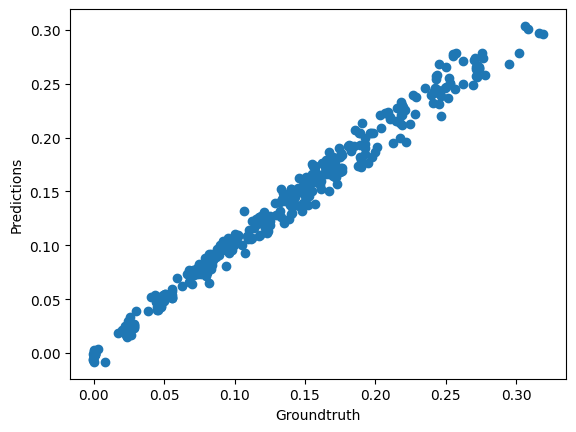

In [14]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Groundtruth")
plt.ylabel("Predictions")

In [15]:
#for idx, prediction in enumerate(predictions):
#    print(f'Groundtruth: {Y_test[idx]}. Predicted: {prediction}')

## Predict CoM -> y

### Linear Regression

In [16]:
# Input
X = np.hstack((X_motion_CoM_acceleration_FR_RL[:, 0:1], # current reference velocity
               X_motion_CoM_acceleration_FR_RL[:, 3:4], # actual velocity
               X_motion_CoM_acceleration_FR_RL[:, 6:8], # FL position
               X_motion_CoM_acceleration_FR_RL[:, 9:11], # FR position
               X_motion_CoM_acceleration_FR_RL[:, 12:14], # RL position
               X_motion_CoM_acceleration_FR_RL[:, 15:17])) # RR position

# Labels
Y = np.array([Y_motion_CoM_acceleration_FR_RL[:, 1]]).T

assert Y.shape[0] == X.shape[0]

# Split dataset and fit best model
X_test, Y_test, predictions, model_fr_com_y = find_best_model(X, Y, runs=5000)

R2:  0.9048117284159497
RMSE:  0.0017589969441689653
The lowest error is:  1.9797308829078413e-06
The highest error is:  0.004823847900639812
The avg. error is:  0.0013607625284933606


In [17]:
model_fr_com_y.coef_

array([[ 0.02240725, -0.01769868,  0.04851553,  0.0044649 ,  0.00978158,
        -0.07848464, -0.01821843, -0.03730028, -0.07432889,  0.18059606]])

In [18]:
model_fr_com_y.intercept_

array([-0.01957075])

Text(0, 0.5, 'Predictions')

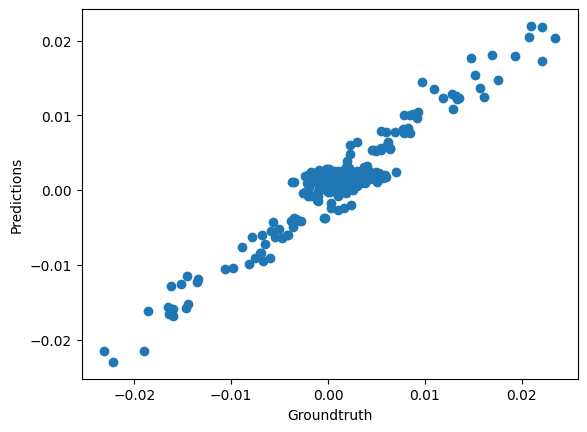

In [19]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Groundtruth")
plt.ylabel("Predictions")

In [20]:
#for idx, prediction in enumerate(predictions):
#    print(f'Groundtruth: {Y_test[idx]}. Predicted: {prediction}')